# gssnng
Gene Set Scoring on the Nearest Neighbor Graph (gssnng) for Single Cell RNA-seq (scRNA-seq)

In this notebook, we'll take our AnnData object and produce smoothed count matrices. 

By operating on the nearest neighbor graph, we create a mini-pseudobulk expression profile of neighbors for each cell, thus smoothing the count data.  Important parameters therefore include the number of neighbors for each cell and the "smooth_mode" which takes "adjacency" or "connectivity". This dictates how the neighborhood graph is used. "Adjacency" weights all neighbors equally, while "connectivity" puts more weight on close neighbors.

https://github.com/IlyaLab/gssnng

Notebook author: David L Gibbs (david.gibbs@isbscience.org)

In [2]:
# first let's install the package from github
# and clone the repo for the example data
!pip install git+https://github.com/IlyaLab/gssnng
#!git clone https://github.com/IlyaLab/gssnng

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/IlyaLab/gssnng to c:\users\daveg\appdata\local\temp\pip-req-build-udhw62tu
  Resolved https://github.com/IlyaLab/gssnng to commit 136fac072987222e0b237a0e0451a235fda189e2
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gssnng: filename=gssnng-0.5.0-py3-none-any.whl size=16418 sha256=ff8d7b6f38d818379ee07193b70fe015e6ef74f1e27e616004459af7b5407c61
  Stored in directory: C:\Users\daveg\AppData\Local\Temp\pip-ephem-wheel-cache-jxkmksmo\wheels\12\a6\0f\abc756a7905a1550ea23508aae0e5967ea746fa66ce17b5405
Successfully built gssnng


  Running command git clone --filter=blob:none --quiet https://github.com/IlyaLab/gssnng 'C:\Users\daveg\AppData\Local\Temp\pip-req-build-udhw62tu'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from gssnng import score_cells, smoothing
import anndata
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read in the 10x genomics example data set, same as used in the scanpy tuts
q = sc.datasets.pbmc3k_processed()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

To generate a smoothed count matrix, we'll be using the smooth_adata function. The usage is very similar to calculating gene set scores.  Neighbors are collected depending on the groupby parameter, so smoothing will not cross boundries such as cell type. 

In [36]:

q_list = smoothing.smooth_adata(adata=q,                    # AnnData object
                                  groupby='louvain',          # Will sample neighbors within this group, can take a list
                                  smooth_mode='connectivity', # Smooths matrix using distance weights from NN graph.
                                  recompute_neighbors=32,     # Rebuild nearest neighbor graph with groups, 0 turns off function
                                  cores=4)                    # Smoothed in parallel.


... and dropping gssnng_groupby column...
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
RECOMPUTING KNN
**done**


TLDR; <br>  If you want to just make a new AnnData object with smoothed expression in X.  Then do this:

In [ ]:
# making a new AnnData object with smoothed counts.

 # q_list is a list of tuples  (anndata, label)
for qi in q_list:
    print(qi[1])  # the groupby-category names
    qi[0].X = qi[0].obsm['X_smooth'].copy()

# the new AnnData object
q_new = anndata.concat([qi[0] for qi in q_list])

The result is a list of AnnData objects with an entry for each groupby group, here each cluster. Here, q_list is a list of tuples, where the first element of each tuple is the smoothed AnnData, and the second element is the groupby name.

In [37]:
for qi in q_list:
    # getting the groupby label out of the .obs table.
    print(qi[0].obs.louvain.iloc[0])
    # and comparing it to the tuple lable.
    print(qi[1])  # the groupby-category names
    print("----")

Megakaryocytes
Megakaryocytes
----
NK cells
NK cells
----
B cells
B cells
----
Dendritic cells
Dendritic cells
----
FCGR3A+ Monocytes
FCGR3A+ Monocytes
----
CD8 T cells
CD8 T cells
----
CD14+ Monocytes
CD14+ Monocytes
----
CD4 T cells
CD4 T cells
----


The result is a list of AnnData objects with an entry for each groupby group, here each cluster.  However, the order is not guaranteed to be the same each time!

In [49]:
# get the index for CD8 T cells
cell_i = np.where([qi[1] == 'CD8 T cells' for qi in q_list] )[0][0]

# the name of the AnnData object
q_list[cell_i][1]

'CD8 T cells'

In [50]:
# the AnnData object
q_list[cell_i][0]

AnnData object with n_obs × n_vars = 316 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'gssnng_groupby'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'X_smooth'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

 Let's copy out the CD8 T cells object.

In [52]:
q_tcells = q_list[cell_i][0].copy()

In [53]:
q_tcells.obs

,n_genes,percent_mito,n_counts,louvain,gssnng_groupby
index,,,,,
AAACGCACTGGTAC-1,782,0.016644,2163.0,CD8 T cells,CD8 T cells
AAACGCTGACCAGT-1,783,0.038161,2175.0,CD8 T cells,CD8 T cells
AAACGCTGGTTCTT-1,790,0.030973,2260.0,CD8 T cells,CD8 T cells
AAAGAGACGGACTT-1,458,0.023458,1151.0,CD8 T cells,CD8 T cells
AAATCCCTCCACAA-1,428,0.019895,955.0,CD8 T cells,CD8 T cells
...,...,...,...,...,...
TTCGTATGGATAGA-1,873,0.013131,1980.0,CD8 T cells,CD8 T cells
TTGCATTGAGCTAC-1,721,0.017588,1990.0,CD8 T cells,CD8 T cells
TTGCTAACACCAAC-1,788,0.021376,1918.0,CD8 T cells,CD8 T cells


The original counts are still in X

In [54]:
q_tcells.X[1:5,1:5]

array([[-0.27648515, -0.04273415, -0.4603669 , -0.5231178 ],
       [-0.27562705, -0.04569191, -0.46267566, -0.52448225],
       [-0.23244892, -0.04352009, -0.36709467, -0.37063497],
       [-0.2236184 , -0.04393958,  3.212301  , -0.3404437 ]],
      dtype=float32)

The smoothed counts are found in .obsm['X_smooth']

In [55]:
q_tcells.obsm['X_smooth'][1:5,1:5]

array([[-0.19636968, -0.04643329, -0.35782764, -0.07625866],
       [-0.1906654 , -0.04879647,  0.11424041,  0.22075397],
       [-0.06711337, -0.04669264,  0.03343431,  0.09068189],
       [-0.17287945, -0.04654046, -0.03668978, -0.03114599]])

Let's compare the values for a single gene.

In [56]:
np.where(q_tcells.var.index == 'C1orf86')[0]

array([3], dtype=int64)

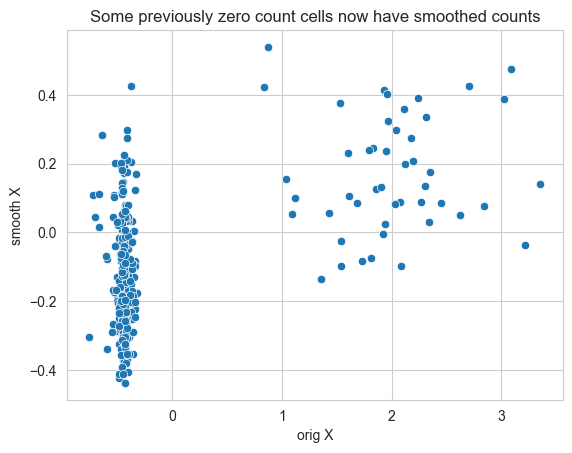

In [57]:
x1 = q_tcells.X
x2 = q_tcells.obsm['X_smooth']

#fig = sns.scatterplot(x=x1[:,1474], y=x2[:,1474])
fig = sns.scatterplot(x=x1[:,3], y=x2[:,3])

plt.xlabel("orig X")
plt.ylabel("smooth X")
plt.title('Some previously zero count cells now have smoothed counts')
plt.show(fig)

The cells that have higher expression in the original count matrix, still have higher expression, but a number of cells that had zero counts in the origianl matrix now have some smoothed count. That makes sense if they're connected to neighboring cells with measured expression in this gene.


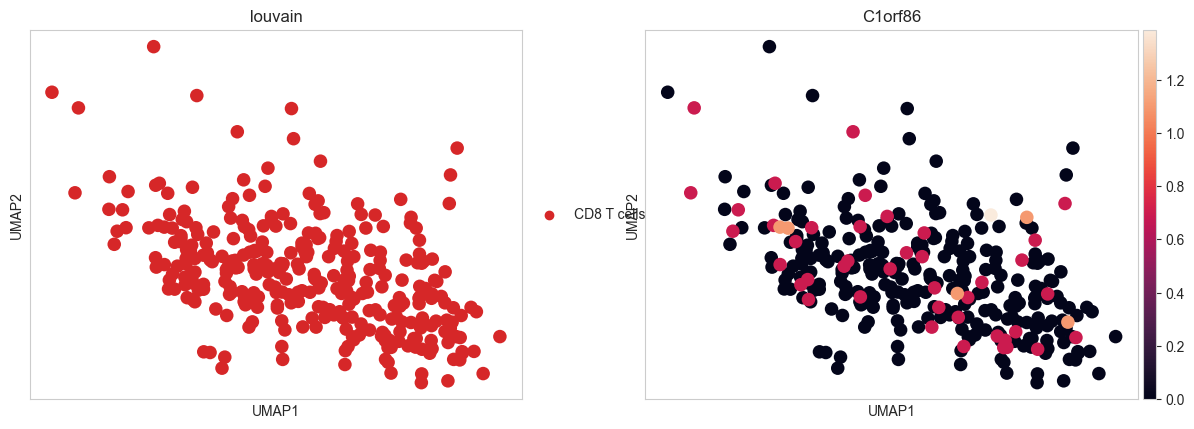

In [58]:
sc.pl.umap(q[q.obs.louvain == 'CD8 T cells'], color=['louvain','C1orf86'],)

Now let's copy the smoothed matrix over the original counts matrix.  Then we'll compare X to the X_smooth to make sure they're the same.

In [59]:
q_tcells.X = q_tcells.obsm['X_smooth'].copy()

In [60]:
q_tcells.obs

,n_genes,percent_mito,n_counts,louvain,gssnng_groupby
index,,,,,
AAACGCACTGGTAC-1,782,0.016644,2163.0,CD8 T cells,CD8 T cells
AAACGCTGACCAGT-1,783,0.038161,2175.0,CD8 T cells,CD8 T cells
AAACGCTGGTTCTT-1,790,0.030973,2260.0,CD8 T cells,CD8 T cells
AAAGAGACGGACTT-1,458,0.023458,1151.0,CD8 T cells,CD8 T cells
AAATCCCTCCACAA-1,428,0.019895,955.0,CD8 T cells,CD8 T cells
...,...,...,...,...,...
TTCGTATGGATAGA-1,873,0.013131,1980.0,CD8 T cells,CD8 T cells
TTGCATTGAGCTAC-1,721,0.017588,1990.0,CD8 T cells,CD8 T cells
TTGCTAACACCAAC-1,788,0.021376,1918.0,CD8 T cells,CD8 T cells


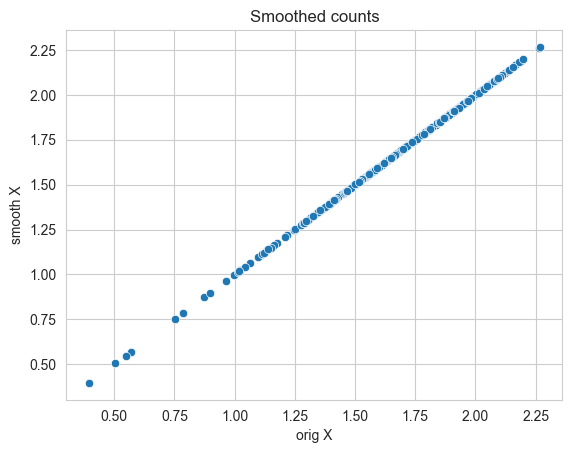

In [61]:
x1 = q_tcells.X
x2 = q_tcells.obsm['X_smooth']

fig = sns.scatterplot(y=x1[:,1474],
                      x=x2[:,1474])

plt.xlabel("orig X")
plt.ylabel("smooth X")
plt.title('Smoothed counts')
plt.show(fig)

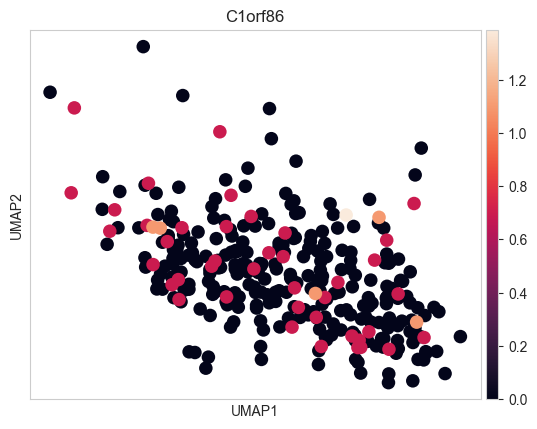

In [64]:
# and the original counts
sc.pl.umap(q[q.obs.louvain == 'CD8 T cells'], color=['C1orf86'])

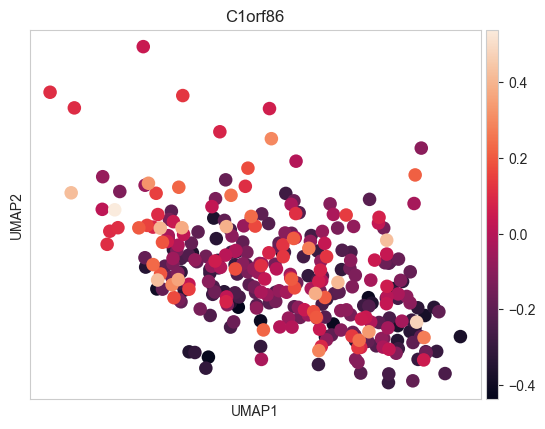

In [63]:
# smoothed counts
sc.pl.umap(q_tcells, color=['C1orf86'], use_raw=False)

Now to assemble everything into one AnnData object, where X is replaced by X_smooth.

In [66]:
 # q_list is a list of tuples
 for qi in q_list:
     print(qi[1])  # the groupby-category names
     qi[0].X = qi[0].obsm['X_smooth'].copy()

Megakaryocytes
NK cells
B cells
Dendritic cells
FCGR3A+ Monocytes
CD8 T cells
CD14+ Monocytes
CD4 T cells


In [67]:
q_new = anndata.concat([qi[0] for qi in q_list])

In [68]:
q_new

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'gssnng_groupby'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'X_smooth'

E:\Work\cruk\Lung Data Paper Prep\lung_data_prep\venv\lib\site-packages\scanpy\plotting\_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


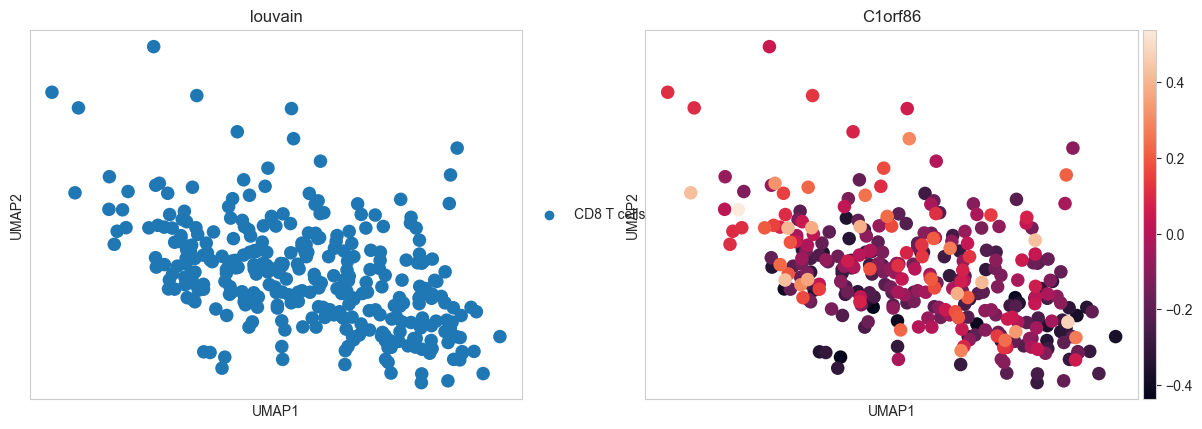

In [69]:
sc.pl.umap(q_new[q_new.obs.louvain == 'CD8 T cells'], color=['louvain','C1orf86'], use_raw=False)

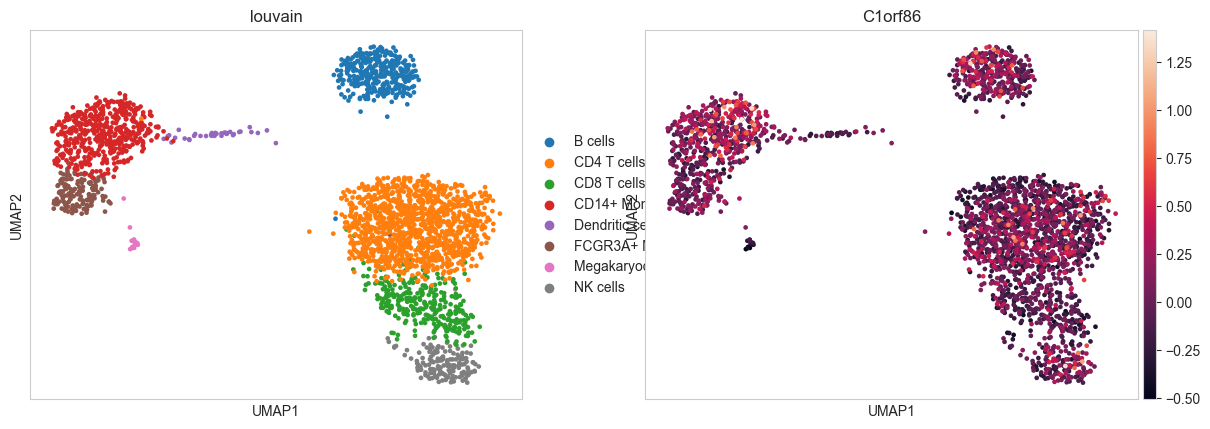

In [71]:
sc.pl.umap(q_new, color=['louvain','C1orf86'], use_raw=False)

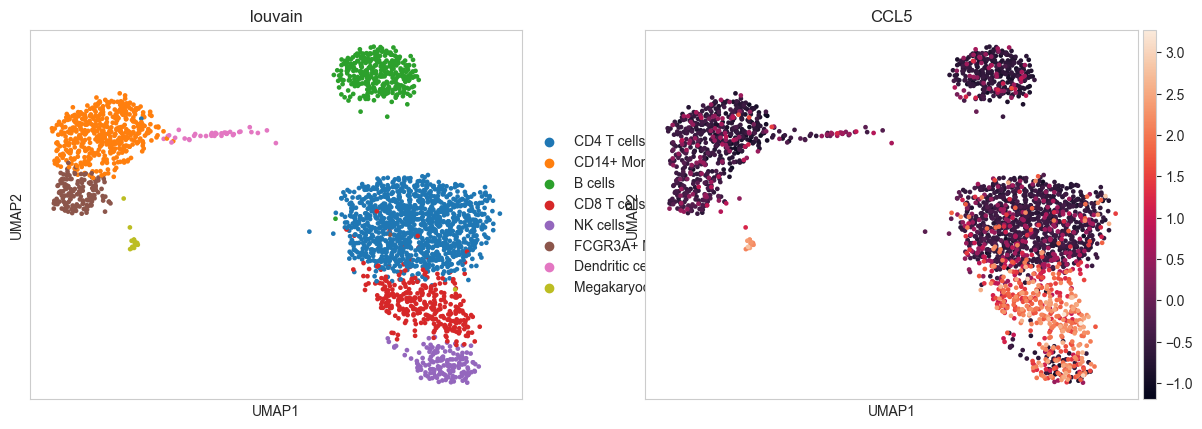

In [72]:
sc.pl.umap(q, color=['louvain','CCL5'], use_raw=False)

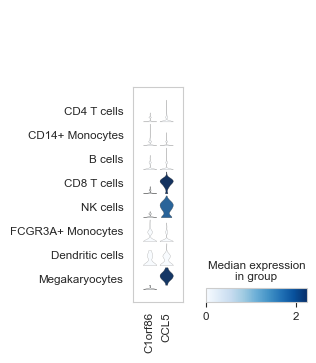

In [78]:
# original counts in the raw layer
sc.pl.stacked_violin(q, groupby='louvain', var_names=['C1orf86','CCL5'], use_raw=True)

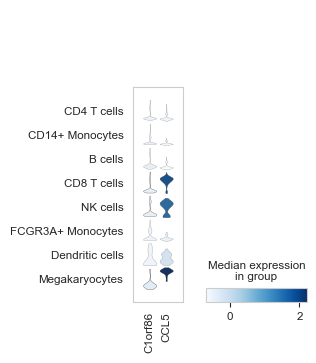

In [77]:
# smoothed
sc.pl.stacked_violin(q, groupby='louvain', var_names=['C1orf86','CCL5'], use_raw=False)

If we look at the Megakaryocytes, most of the cells show some expression.  So, when they're smoothed, the entire distribution shifts towards higher smoothed expression.

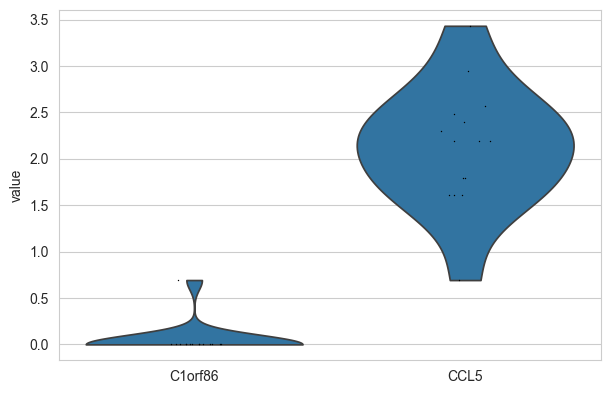

In [81]:
# original counts
sc.pl.violin(q[q.obs.louvain == 'Megakaryocytes'], keys=['C1orf86','CCL5'], use_raw=True)

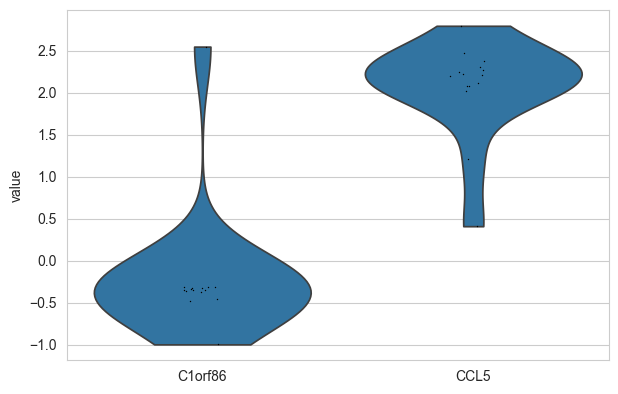

In [82]:
#smoothed counts
sc.pl.violin(q[q.obs.louvain == 'Megakaryocytes'], keys=['C1orf86','CCL5'], use_raw=False)